In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library("rjags")
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

# Running TADA
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, data$dn.mis3, data$case.mis3+data$trans.mis3,
 data$ctrl.mis3+data$ntrans.mis3))


count.mu.Data <- cbind(counts[, 1:3], data$mut.rate*mu.frac[1])

Loading required package: coda
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs


In [46]:
%%R
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, data$dn.mis3, data$case.mis3+data$trans.mis3,
 data$ctrl.mis3+data$ntrans.mis3))


count.mu.Data <- cbind(counts[, 1:3], data$mut.rate*mu.frac[1])



y <- as.numeric(counts[, 1])
murate = data$mut.rate*mu.frac[1]

Ncount <- N
NN <- length(y)

dataJags <- list(y = y,
              alpha0 = c(1, 1),
  
              NN = NN,
              T = c(NA, rep(NA, NN - 2), NA),
              murate = murate,
#              m1 = m1, m2 = m2,
              Ndn = N$dn)

jagsFile = "model {

           p1[1:2] ~ ddirch(alpha0[])
          gamma.mean ~ dnorm(20, 10)I(0, )
           beta.mean ~ dnorm(0.5, 0.2)I(0, )

#           gamma.mean ~ dunif(5, 50)
 #          beta.mean ~ dunif(0.01, 1)
           #beta.mean <- 1

for (i in 1:NN){
           gammaAll[i] ~ dgamma(gamma.mean*beta.mean, beta.mean)

           m[i, 1] <- 2*Ndn*murate[i]
           m[i, 2] <- 2*Ndn*murate[i]*gammaAll[i]


           y[i] ~ dpois(mu0[i])
           mu0[i] <- m[i, T[i]]
           T[i] ~ dcat(p1[])
       }

}
"


n.chains = 1
n.adapt = 1000
inits = list(p1 = c(0.95, 0.5), gamma.mean = 20, beta.mean = 1)
        mixture <- jags.model(textConnection(jagsFile), inits = inits,
                              data = dataJags, n.chains = n.chains, n.adapt = n.adapt)

nUpdate = 10000
update(mixture, nUpdate)

n.iter = 20000
thin = 5
xem <- coda.samples(mixture, c('mu0', 'T', 'gammaAll', 'gamma.mean', 'beta.mean', 'p1'),
                    n.iter = n.iter, thin = thin)

a0 <- xem[[1]]
##Each chain will produce a list

In [3]:
%%R
load("resultRunXem.RData")

Error: cannot allocate vector of size 1.7 Gb


In [4]:
%%R
library("data.table")


data.table 1.9.4  For help type: ?data.table
*** NB: by=.EACHI is now explicit. See README to restore previous behaviour.


In [3]:
%%R
load("resultRunXem.gamma.beta.p1.p2.RData")

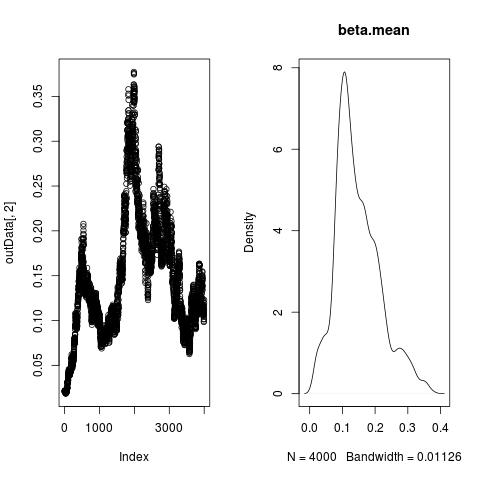

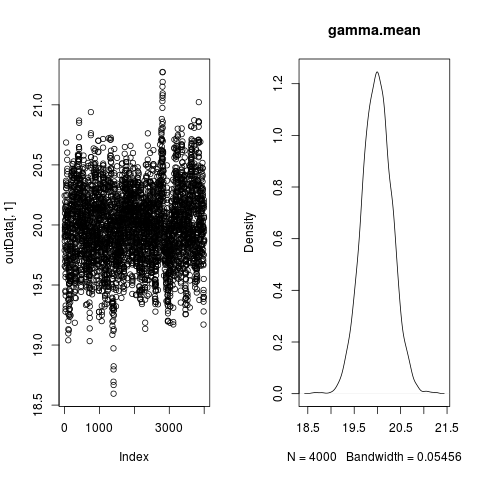

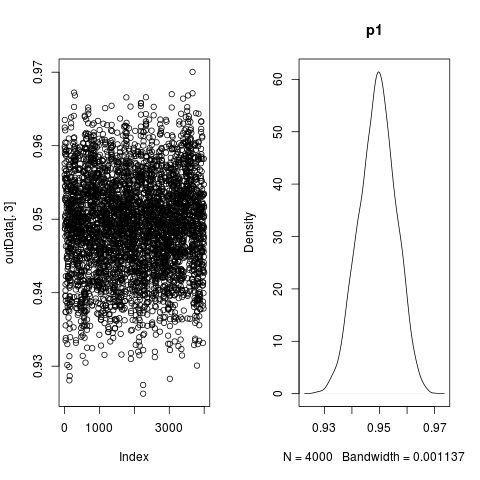

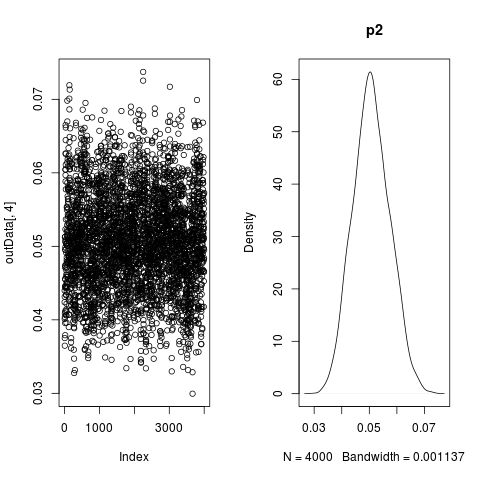

In [6]:
%%R
par(mfrow = c(1, 2))
plot(outData[, 1])
plot(density(outData[, 1]), main = 'gamma.mean')
plot(outData[, 2])
plot(density(outData[, 2]), main = 'beta.mean')

plot(outData[, 3])
plot(density(outData[, 3]), main = 'p1')

plot(outData[, 4])
plot(density(outData[, 4]), main = 'p2')







In [7]:
%%R
apply(outData, 2, mean)

x.gamma.mean  x.beta.mean         x.p1         x.p2 
 19.98853312   0.14725656   0.94921698   0.05078302 


In [10]:
#!gist -p test_tada_denovo_rjags.ipynb

In [11]:
!gist -u https://gist.github.com/cf30556544a0c362fb17 test_tada_denovo_rjags.ipynb

https://gist.github.com/cf30556544a0c362fb17
